# CIFAR10 classification

In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
import sys

sys.path.append("..")

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from ndswin import SwinClassifier

In [6]:
def minmax(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)


def accuracy(pred, y):
    predicted_labels = torch.argmax(pred, dim=1)
    correct_predictions = predicted_labels == y
    accuracy = correct_predictions.sum().item() / correct_predictions.numel()
    return accuracy * 100

### Dataset (torchvision)
Conveniently using the `torchvision.datasets` implementation of CIFAR.

In [7]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

traindata = datasets.CIFAR10(
    root="cifar/", train=True, download=True, transform=train_transform
)

valdata = datasets.CIFAR10(
    root="cifar/", train=False, download=True, transform=val_transform
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

100%|██████████| 170M/170M [00:06<00:00, 25.2MB/s] 


Extracting datasets/cifar-10-python.tar.gz to datasets/
Files already downloaded and verified


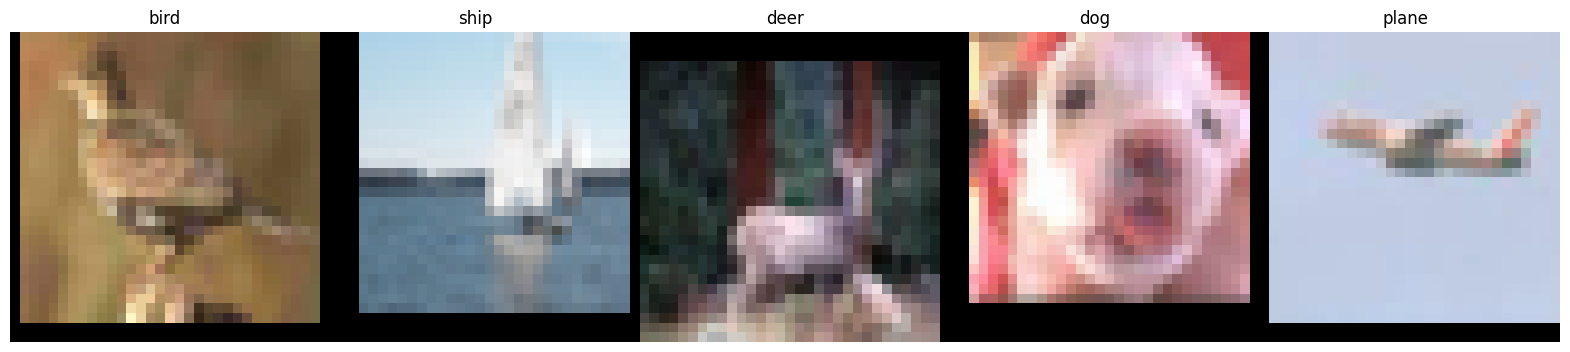

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(20, 8))
fig.subplots_adjust(wspace=0, hspace=0)

idxs = np.random.randint(0, len(traindata), 5)
images = np.stack([traindata[i][0].numpy() for i in idxs], 0)
c_idxs = [traindata[i][1] for i in idxs]

for i in range(5):
    image_ = np.transpose(images[i], (1, 2, 0))
    image_ = minmax(image_)
    ax[i].imshow(image_)
    ax[i].axis("off")
    ax[i].set_title(classes[c_idxs[i]])

## Swin Transformer
Simple 2D swin 10-class classifier, made of a patch embedding layer, a stack of alternated shifted window transformers and downsample (patch merging) layers, and finally a MLP head for classification.

In [27]:
N_EPOCHS = 100

model = SwinClassifier(
    128,
    resolution=(32, 32),
    num_classes=10,
    patch_size=(2, 2),
    window_size=(4, 4),
    depth=(4, 4),
    num_heads=(4, 8),
    use_abs_pe=True,
    use_conv=True,
)

print(f"Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, N_EPOCHS, 1e-6)

Parameters: 4.7M


## Training

In [28]:
device = "cuda"

In [ ]:
trainloader = DataLoader(traindata, 512, num_workers=2, shuffle=True, pin_memory=True)
valloader = DataLoader(valdata, 512, num_workers=2, shuffle=False, pin_memory=True)

In [29]:
model = model.to(device)

results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for e in range(1, N_EPOCHS + 1):
    # train
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for sample in trainloader:
        x, y = sample[0].to(device), sample[1].to(device)
        pred = model(x)
        loss = F.cross_entropy(pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item()
        train_acc += accuracy(pred, y)

    sched.step()

    # eval
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for sample in valloader:
            x, y = sample[0].to(device), sample[1].to(device)
            pred = model(x)

            val_loss += F.cross_entropy(pred, y).item()
            val_acc += accuracy(pred, y)

    results["train_loss"].append(train_loss / len(trainloader))
    results["train_acc"].append(train_acc / len(trainloader))
    results["val_loss"].append(val_loss / len(valloader))
    results["val_acc"].append(val_acc / len(valloader))
    e_s = str(e).zfill(len(str(N_EPOCHS)))
    print(
        f"[{e_s}] train/loss: {results['train_loss'][-1]:.2f}, "
        f"train/acc: {results['train_acc'][-1]:.2f}%, "
        f"val/loss: {results['val_loss'][-1]:.2f}, "
        f"val/acc: {results['val_acc'][-1]:.2f}%"
    )

[001] train/loss: 2.14, train/acc: 19.32%, val/loss: 1.95, val/acc: 26.54%
[002] train/loss: 1.90, train/acc: 28.49%, val/loss: 1.81, val/acc: 32.55%
[003] train/loss: 1.76, train/acc: 34.18%, val/loss: 1.62, val/acc: 38.87%
[004] train/loss: 1.63, train/acc: 39.02%, val/loss: 1.50, val/acc: 43.24%
[005] train/loss: 1.53, train/acc: 43.35%, val/loss: 1.43, val/acc: 47.59%
[006] train/loss: 1.44, train/acc: 47.09%, val/loss: 1.35, val/acc: 50.48%
[007] train/loss: 1.37, train/acc: 50.09%, val/loss: 1.26, val/acc: 54.42%
[008] train/loss: 1.30, train/acc: 53.14%, val/loss: 1.22, val/acc: 55.82%
[009] train/loss: 1.24, train/acc: 55.18%, val/loss: 1.20, val/acc: 57.37%
[010] train/loss: 1.21, train/acc: 56.54%, val/loss: 1.14, val/acc: 59.59%
[011] train/loss: 1.16, train/acc: 58.23%, val/loss: 1.07, val/acc: 61.78%
[012] train/loss: 1.11, train/acc: 60.11%, val/loss: 1.04, val/acc: 62.40%
[013] train/loss: 1.07, train/acc: 61.60%, val/loss: 0.98, val/acc: 65.44%
[014] train/loss: 1.03, t

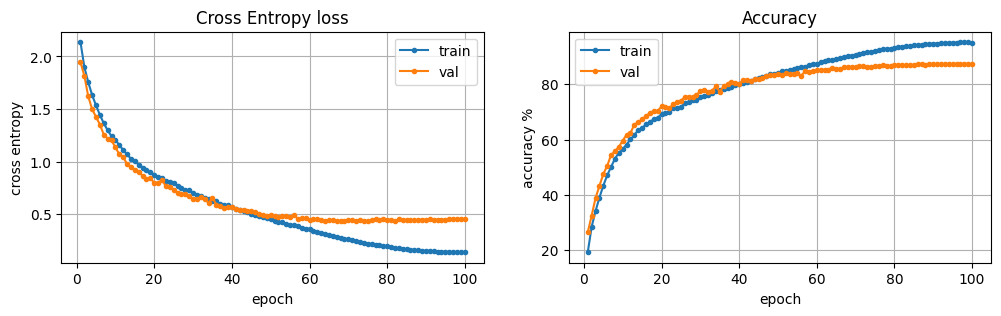

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
xs = np.arange(1, len(results["train_loss"]) + 1)
ax[0].set_title("Cross Entropy loss")
ax[0].plot(xs, results["train_loss"], ".-", label="train")
ax[0].plot(xs, results["val_loss"], ".-", label="val")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("cross entropy")
ax[0].legend()
ax[0].grid()

ax[1].set_title("Accuracy")
ax[1].plot(xs, results["train_acc"], ".-", label="train")
ax[1].plot(xs, results["val_acc"], ".-", label="val")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy %")
ax[1].legend()
ax[1].grid()

## Qualitative model predictions

/tmp/ipykernel_3275485/440533620.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_ = np.array(np.transpose(image[i], (1, 2, 0)))


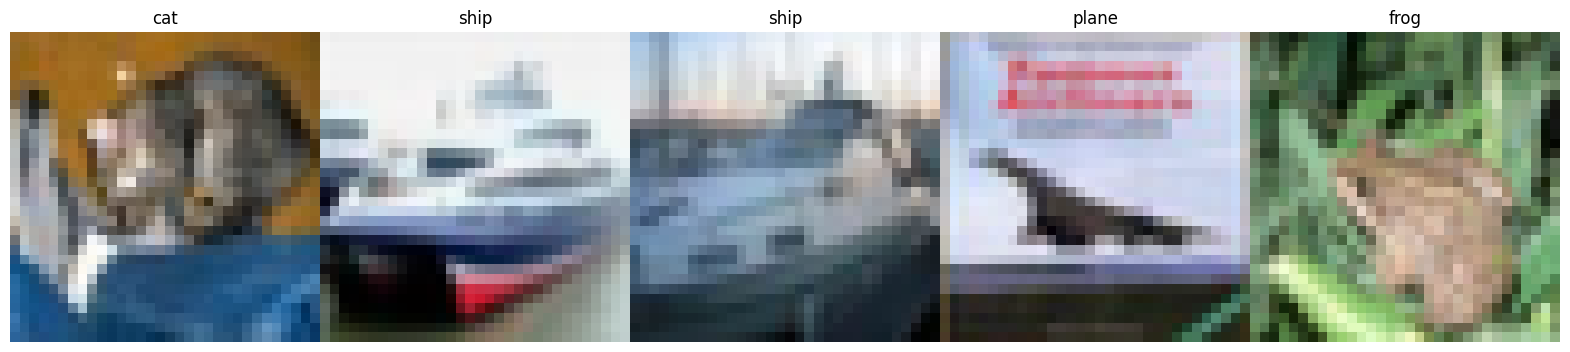

In [31]:
fig, ax = plt.subplots(1, 5, figsize=(20, 8))
fig.subplots_adjust(wspace=0, hspace=0)
image, _ = next(iter(valloader))
c = model(image.to(device)).detach().cpu().argmax(-1)

for i in range(5):
    image_ = np.array(np.transpose(image[i], (1, 2, 0)))
    image_ = minmax(image_)
    ax[i].imshow(image_)
    ax[i].axis("off")
    ax[i].set_title(classes[c[i].item()])